This project is principally an example of cleaning and combining data into a single dataset for analysis. We'll be looking at school and demographic data for new york city, and particularly at SAT scores for various schools. All the data we use is available on the city of new york open access website. You can get to the individual pages by take the API addresses in the first step here, and removing the .json suffix. This data can be accessed anonymously, but the API suggests using a token, which can be generated through the same links. If you don't want to generate a token, remove the headers parameter from the requests.get command.

There are a number of data exploration steps removed here to make the process flow a little cleaner. One of the important things that was discovered right at the beginning of the data discovery process is that each file has a key (or the required items to construct a unique key) which uniquely identifies each school, called the dbn (district borough number). Most datasets are unique on this key, though some will require some processing to get them unique on this key.

# Read in the data

In [1]:
import requests
import pandas as pd
import numpy

# Token supplied in header. Redacted here.
headers = {'X-App-Token': 'V7z166ljThtXo1EpzmeSbdvvZ'}

# We'll pick the data from the API's of the original source.
# Limit parameter required because default of api is to return only 1000 rows.
data_files = [
    "https://data.cityofnewyork.us/resource/sg2c-qbjf.json?$limit=30000",
    "https://data.cityofnewyork.us/resource/qgts-mthv.json?$limit=30000",
    "https://data.cityofnewyork.us/resource/tvf6-bvfe.json?$limit=30000",
    "https://data.cityofnewyork.us/resource/ns8x-c6af.json?$limit=30000",
    "https://data.cityofnewyork.us/resource/2u2u-zka4.json?$limit=30000",
    "https://data.cityofnewyork.us/resource/734v-jeq5.json?$limit=30000"
]
# Names for the individual datasets (same order as above)
data_names = [
    "ap_2010",
    "class_size",
    "demographics",
    "graduation",
    "hs_directory",
    "sat_results"
]

# Storing the datasets in a dictionary
data = {}

for i,f in enumerate(data_files):
    # Get the data and convert to dataframes
    response = requests.get(f,headers=headers)
    d = pd.DataFrame(response.json())
    data[data_names[i]] = d

We have some survey data files that we want to include as well. These aren't available through an API, but can be downloaded as csv files from: https://data.cityofnewyork.us/Education/NYC-School-Survey-2011/mnz3-dyi8

# Read in the surveys

In [2]:
all_survey = pd.read_csv("C:\\Users\\User\\Documents\\Python projects\\Shared\\masterfile11_gened_final.txt", delimiter="\t", encoding='windows-1252')
d75_survey = pd.read_csv("C:\\Users\\User\\Documents\\Python projects\\Shared\\masterfile11_d75_final.txt", delimiter="\t", encoding='windows-1252')

# Merge the two survey files into a single dataset
survey = pd.concat([all_survey, d75_survey], axis=0)

# We are only really interested in a subset of fields here, so we'll trim down this dataset a bit.
# The definitions for these fields are available in the data dictionary file in the zip download from the above link.
survey_fields = [
    "dbn", 
    "rr_s", 
    "rr_t", 
    "rr_p", 
    "N_s", 
    "N_t", 
    "N_p", 
    "saf_p_11", 
    "com_p_11", 
    "eng_p_11", 
    "aca_p_11", 
    "saf_t_11", 
    "com_t_11", 
    "eng_t_10", 
    "aca_t_11", 
    "saf_s_11", 
    "com_s_11", 
    "eng_s_11", 
    "aca_s_11", 
    "saf_tot_11", 
    "com_tot_11", 
    "eng_tot_11", 
    "aca_tot_11",
]
survey = survey.loc[:,survey_fields]

# Add the survey to the dictionary of datasets
data["survey"] = survey

In [3]:
data['survey'].head()

,dbn,rr_s,rr_t,rr_p,N_s,N_t,N_p,saf_p_11,com_p_11,eng_p_11,...,eng_t_10,aca_t_11,saf_s_11,com_s_11,eng_s_11,aca_s_11,saf_tot_11,com_tot_11,eng_tot_11,aca_tot_11
0,01M015,NaN,88,60,NaN,22.0,90.0,8.5,7.6,7.5,...,NaN,7.9,NaN,NaN,NaN,NaN,8.0,7.7,7.5,7.9
1,01M019,NaN,100,60,NaN,34.0,161.0,8.4,7.6,7.6,...,NaN,9.1,NaN,NaN,NaN,NaN,8.5,8.1,8.2,8.4
2,01M020,NaN,88,73,NaN,42.0,367.0,8.9,8.3,8.3,...,NaN,7.5,NaN,NaN,NaN,NaN,8.2,7.3,7.5,8.0
3,01M034,89.0,73,50,145.0,29.0,151.0,8.8,8.2,8.0,...,NaN,7.8,6.2,5.9,6.5,7.4,7.3,6.7,7.1,7.9
4,01M063,NaN,100,60,NaN,23.0,90.0,8.7,7.9,8.1,...,NaN,8.1,NaN,NaN,NaN,NaN,8.5,7.6,7.9,8.0


# Add dbn column
We need create a dbn column to use as a join key in the class size dataset.

In [4]:
# Class size has no DBN field, but it does have csd and school codes which can be combined to make DBN.
# It's necessary that csd be two characters, padded with a zero if it is currently just a one digit number.

# Funciton to make a padded string from number
def pad_csd(num):
    string_representation = str(num)
    if len(string_representation) > 1:
        return string_representation
    else:
        return "0" + string_representation

# Apply the function to create a padded column, then create a DBN column with a simple vectorized concatenation.
data["class_size"]["padded_csd"] = data["class_size"]["csd"].apply(pad_csd)
data["class_size"]["dbn"] = data["class_size"]["padded_csd"] + data["class_size"]["school_code"]

# Convert columns to numeric
There are lots of fields in the various datasets that we are going to want to aggregate on or perform correlation calculations with, so we need to change their type to numeric. Additionally, we want the latitude and longitude fields in the directory to be numeric so we can plug them into our plotter for maps.

In [5]:
# SAT result columns first
cols = ['sat_math_avg_score', 'sat_critical_reading_avg_score', 'sat_writing_avg_score']
for c in cols:
    # Convert to numeric. Coerce replaces errors with NaN.
    data["sat_results"][c] = pd.to_numeric(data["sat_results"][c], errors="coerce")

# The overall sat score is the sum of the scores for the three core subjects.
data['sat_results']['sat_score'] = data['sat_results'][cols[0]] + data['sat_results'][cols[1]] + data['sat_results'][cols[2]]

# Next the latitude and longitude columns. We need to start by parsing the lat and longitudes from the location columns.
# We'll use functions to pick the right value from the location_1 dictionary.
def find_lat(location):
    return location['coordinates'][0]

def find_lon(location):
    return location['coordinates'][0]

data["hs_directory"]["lat"] = data["hs_directory"]["location_1"].apply(find_lat)
data["hs_directory"]["lon"] = data["hs_directory"]["location_1"].apply(find_lon)

# And then convert these two columns to numerics
data["hs_directory"]["lat"] = pd.to_numeric(data["hs_directory"]["lat"], errors="coerce")
data["hs_directory"]["lon"] = pd.to_numeric(data["hs_directory"]["lon"], errors="coerce")

# For class size, we're going to want to look at average class size and how that correlates
data['class_size']['average_class_size'] = pd.to_numeric(data['class_size']['average_class_size'], errors="coerce")

# In the AP scores set, we're going to want to aggregate on a few columns
cols = ['ap_test_takers_', 'total_exams_taken', 'number_of_exams_with_scores_3_4_or_5']
for col in cols:
    data["ap_2010"][col] = pd.to_numeric(data["ap_2010"][col], errors="coerce")

In [7]:
# A slightly different strategy for the demographics dataset, as there are quite a few columns I'm likely to want to test.
cols = data['demographics'].columns.tolist()
for c in cols:
    try:
        data['demographics'][c] = pd.to_numeric(data['demographics'][c], errors="raise")
    except:
        pass
    
data['demographics'].dtypes

asian_num              int64
asian_per            float64
black_num              int64
black_per            float64
ctt_num               object
dbn                   object
ell_num               object
ell_percent          float64
female_num           float64
female_per           float64
fl_percent            object
frl_percent          float64
grade1                object
grade10               object
grade11               object
grade12               object
grade2                object
grade3                object
grade4                object
grade5                object
grade6                object
grade7                object
grade8                object
grade9                object
hispanic_num           int64
hispanic_per         float64
k                     object
male_num             float64
male_per             float64
name                  object
prek                  object
schoolyear             int64
selfcontained_num     object
sped_num             float64
sped_percent  

# Condense datasets
Some datasets contain more data than we need or want, so we're going to cut a few of them down a bit. Additionally, some aren't unique on dbn, so we will address that issue before merging the data.

In [9]:
data['class_size'].head()

,average_class_size,borough,core_course_ms_core_and_9_12_only_,core_subject_ms_core_and_9_12_only_,csd,data_source,grade_,number_of_sections,number_of_students_seats_filled,program_type,school_code,school_name,schoolwide_pupil_teacher_ratio,service_category_k_9_only_,size_of_largest_class,size_of_smallest_class,padded_csd,dbn
0,19.0,M,-,-,1,ATS,0K,1,19,GEN ED,M015,P.S. 015 Roberto Clemente,NaN,-,19,19,01,01M015
1,21.0,M,-,-,1,ATS,0K,1,21,CTT,M015,P.S. 015 Roberto Clemente,NaN,-,21,21,01,01M015
2,17.0,M,-,-,1,ATS,01,1,17,GEN ED,M015,P.S. 015 Roberto Clemente,NaN,-,17,17,01,01M015
3,17.0,M,-,-,1,ATS,01,1,17,CTT,M015,P.S. 015 Roberto Clemente,NaN,-,17,17,01,01M015
4,15.0,M,-,-,1,ATS,02,1,15,GEN ED,M015,P.S. 015 Roberto Clemente,NaN,-,15,15,01,01M015


In [10]:
# SATs are taken by high schoolers (grade 9 - 12). Class size contains info for all ages, so we'll start by filtering this a bit. 
class_size = data["class_size"]
class_size = class_size[class_size["grade_"] == "09-12"]

# Class size isn't unique on DBN yet. Program type has multiple values: GEN ED, SPEC ED, CTT and G&T. We'll stick just to general education.
class_size = class_size[class_size["program_type"] == "GEN ED"]

# Nearly there. The remaining problem columns, causing dbn to be non-unique, are core_course and core_subject.
# We are interested in the overall SAT score and therefore want the general measure of class size for a given score.
# Averaging the subject specific class sizes seems like the best way we can represent school level class size.
class_size = class_size.groupby("dbn").agg(numpy.mean)

# Reset the index and assign the dataset back to the dictionary.
class_size.reset_index(inplace=True)
data["class_size"] = class_size

In [11]:
data['class_size'].head()

,dbn,average_class_size
0,01M292,22.564286
1,01M332,22.000000
2,01M378,33.000000
3,01M448,22.231250
4,01M450,21.200000


In [13]:
# The demographics dataset contains information for several school years. Our survey data relates on to 2011/2012, so we'll filter this to the same.
data["demographics"] = data["demographics"][data["demographics"]["schoolyear"] == 20112012]

In [14]:
data['graduation'].head()

,advanced_regents_n,advanced_regents_of_cohort,advanced_regents_of_grads,cohort,dbn,demographic,dropped_out_n,dropped_out_of_cohort,local_n,local_of_cohort,...,regents_w_o_advanced_of_grads,school_name,still_enrolled_n,still_enrolled_of_cohort,total_cohort,total_grads_n,total_grads_of_cohort,total_regents_n,total_regents_of_cohort,total_regents_of_grads
0,s,NaN,NaN,2003,01M292,Total Cohort,s,NaN,s,NaN,...,NaN,HENRY STREET SCHOOL FOR INTERNATIONAL,s,NaN,5,s,NaN,s,NaN,NaN
1,0,0,0,2004,01M292,Total Cohort,3,0.055,20,0.364,...,0.459,HENRY STREET SCHOOL FOR INTERNATIONAL,15,0.273,55,37,0.673,17,0.309,0.459
2,0,0,0,2005,01M292,Total Cohort,9,0.141,16,0.25,...,0.628,HENRY STREET SCHOOL FOR INTERNATIONAL,9,0.141,64,43,0.672,27,0.422,0.628
3,0,0,0,2006,01M292,Total Cohort,11,0.141,7,0.09,...,0.837,HENRY STREET SCHOOL FOR INTERNATIONAL,16,0.205,78,43,0.551,36,0.462,0.837
4,0,0,0,2006 Aug,01M292,Total Cohort,11,0.141,7,0.09,...,0.841,HENRY STREET SCHOOL FOR INTERNATIONAL,15,0.192,78,44,0.564,37,0.474,0.841


In [15]:
# Graduation dataset. Not unique on dbn due to cohort and demographic. The most recent cohort option is 2006, so we'll use that.
# We'll also stick to total cohort. See the data dictionary for full details on what these columns mean.
data["graduation"] = data["graduation"][data["graduation"]["cohort"] == "2006"]
data["graduation"] = data["graduation"][data["graduation"]["demographic"] == "Total Cohort"]

# Combine the datasets
Finally we are ready to merge the datasets into one.

In [16]:
# Start with the most important set for our analysis, sat results.
combined = data["sat_results"]

# AP_2010 and graduation are missing a lot of the dbn values from the sat results set. To avoid throwing away
# too many of our sat results rows, we'll left join these two into the combined dataset.
combined = combined.merge(data["ap_2010"], on="dbn", how="left")
combined = combined.merge(data["graduation"], on="dbn", how="left")

# The other sets contain more of the same dbn numbers, and also lots of useful data, so we'll inner join them.
to_merge = ["class_size", "demographics", "survey", "hs_directory"]
for m in to_merge:
    combined = combined.merge(data[m], on="dbn", how="inner")

# We've got some null columns. To simplify processing later, we'll just use a fairly naive null handling strategy of 
# filling nulls with the column mean, or zero if that's not possible.
combined = combined.fillna(combined.mean())
combined = combined.fillna(0)

# Add a school district column for mapping

In [17]:
def get_first_two_chars(dbn):
    return dbn[0:2]

combined["school_dist"] = combined["dbn"].apply(get_first_two_chars)

# Find correlations
To start our analysis, we'll just take a quick look at which columns correlate strongly with sat_score.

In [18]:
correlations = combined.corr()
correlations = correlations["sat_score"]
correlations

sat_critical_reading_avg_score          0.986820
sat_math_avg_score                      0.972643
sat_writing_avg_score                   0.987771
sat_score                               1.000000
ap_test_takers_                         0.523140
number_of_exams_with_scores_3_4_or_5    0.463245
total_exams_taken                       0.514333
average_class_size                      0.381014
asian_num                               0.475445
asian_per                               0.570730
black_num                               0.027979
black_per                              -0.284139
ell_percent                            -0.398750
female_num                              0.388631
female_per                              0.112108
fl_percent                                   NaN
frl_percent                            -0.722225
hispanic_num                            0.025744
hispanic_per                           -0.396985
male_num                                0.325520
male_per            

The above list is a little overwhelming, so let's view these graphically.

#  Plot correlations
We'll use pyplot, but while we're at it we'll import basemap for use later. 

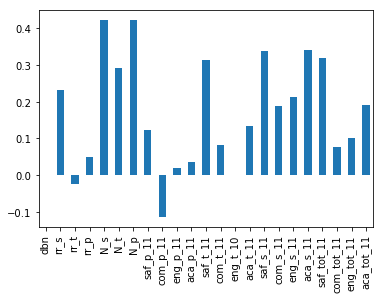

In [19]:
import matplotlib.pyplot as plt
#from mpl_toolkits.basemap import Basemap
%matplotlib inline

# We'll have a look at the survey results and how they correlate with SAT score first.
# We still have the survey fields in a list from earlier.
correlations[survey_fields].plot.bar()

### Results:
Strong correlation between number of survey respondants and SAT score. Perhaps not surprising as more engaged students/parents will generally perform better.

Strong correlation between perception of safety and respect and SAT score. Perceived safety and average SAT score are plotted below.

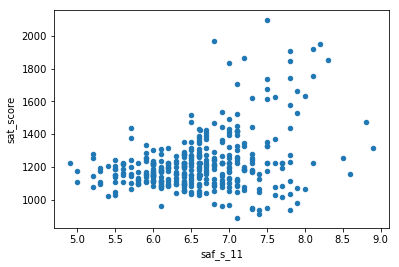

In [20]:
combined.plot.scatter("saf_s_11", "sat_score")

There does appear to be a fairly weak correlation. This makes sense, as it'll be difficult to learn in an unsafe environment.

# Average safety scores by district
We're going to plot average safety scores, per the survey results, by district, as a map. This stage requires basemap, which is not provided by anaconda (python 3.x) by default.

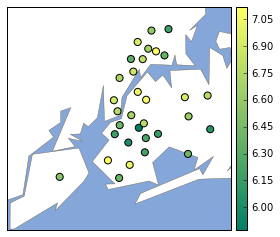

In [12]:
# create districts df as a summary
districts = combined.groupby("school_dist").agg(numpy.mean)
districts.reset_index(inplace=True)

m = Basemap(
    projection='merc',
    llcrnrlat=40.496044,
    urcrnrlat=40.915256,
    llcrnrlon=-74.255735,
    urcrnrlon=-73.700272,
    resolution='i'
)
 
m.drawmapboundary(fill_color='#85A6D9')
m.drawcoastlines(color='#6D5F47', linewidth=.4)
m.drawrivers(color='#6D5F47', linewidth=.4)
m.fillcontinents(color='white',lake_color='#85A6D9')
 
longitudes = districts["lon"].tolist()
latitudes = districts["lat"].tolist()
m.scatter(longitudes, latitudes, s=50, zorder=2, latlon=True, c=districts["saf_s_11"], cmap="summer")
m.colorbar()
plt.show()

Properly drawing useful information from this map requires some domain knowledge, namely some understanding of New York geography, that I don't have, but the map is left in for illustration purposes.

# Racial Differences

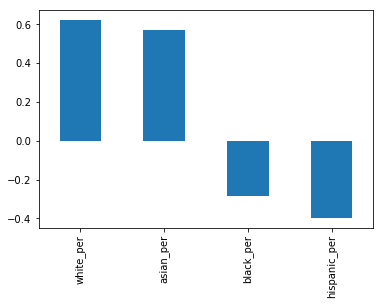

In [21]:
correlations.loc[['white_per','asian_per','black_per','hispanic_per']].plot.bar()

Results are quite stark: Strong positive correlation between SAT score and percentage of white or asian students, and a weaker negative association with percentage of black and hispanic students. It's interesting that, contrary to the impressions given by popular culture, the negative correlation is stronger for hispanic percentage. We'll look at that more closely below.

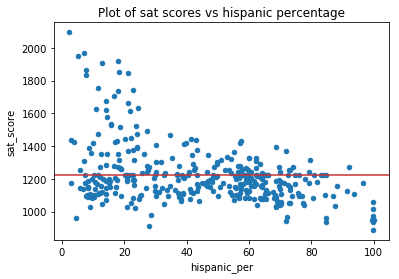

In [36]:
# Plotting average sat scores against hispanic percentage.
combined.plot.scatter('hispanic_per','sat_score')

# Adding a horizontal line for average SAT score.
avg_sat = combined['sat_score'].mean()
plt.axhline(avg_sat, c=(200/255, 50/255, 50/255), alpha=1)
plt.title('Plot of sat scores vs hispanic percentage')
plt.show()

From the scatter plot, the correlation doesn't look all that strong. There are a cluster of very poor performing schools with a very high hispanic percentage. We'll quickly have a look at those.

In [30]:
# Schools with a hispanic percentage over 95%
combined[['school_name','hispanic_per','sat_math_avg_score', 'sat_critical_reading_avg_score', 'sat_writing_avg_score']][combined['hispanic_per'] > 95]

,school_name,hispanic_per,sat_math_avg_score,sat_critical_reading_avg_score,sat_writing_avg_score
44,Manhattan Bridges High School,99.8,378.0,336.0,344.0
82,Washington Heights Expeditionary Learning School,96.7,395.0,380.0,399.0
89,Gregorio Luperon High School for Science and M...,99.8,349.0,339.0,326.0
125,Academy for Language and Technology,99.4,339.0,315.0,297.0
141,International School for Liberal Arts,99.8,333.0,300.0,301.0
176,Pan American International High School at Monroe,99.8,351.0,321.0,298.0
253,Multicultural High School,99.8,322.0,279.0,286.0
286,Pan American International High School,100.0,323.0,317.0,311.0


From some work on google, it appears many of these schools appear designed for immigrants to the US, presumably with a large number of students learning english as a second language. This would certainly explain the poorer than average performace on the SAT tests, which include reading and writing exams. Indeed, for almost all of these schools the read and writing results are worse than the mathematics results.

Another notable result from the scatter graph is that the majority of the schools with an average SAT over 1800 have a quite small proportion of hispanic students. We'll have a quick look at those too.

In [32]:
cols = ['school_name','hispanic_per','sat_score']
combined[cols][(combined['hispanic_per'] < 10) & (combined['sat_score'] > 1800)]

,school_name,hispanic_per,sat_score
37,Stuyvesant High School,2.4,2096.0
151,Bronx High School of Science,7.2,1969.0
187,Brooklyn Technical High School,7.9,1833.0
327,Queens High School for the Sciences at York Co...,7.9,1868.0
356,Staten Island Technical High School,5.3,1953.0


All five of these schools appear on the list of Specialized High Schools of new york. All are selective, requiring that a student pass an additional test to enroll (the SHSAT). Apparently the SHSAT has come under scrutiny for being biased against black and hispanic students. In any case, the selective nature of these schools explains the high sat scores.

# Gender correlations

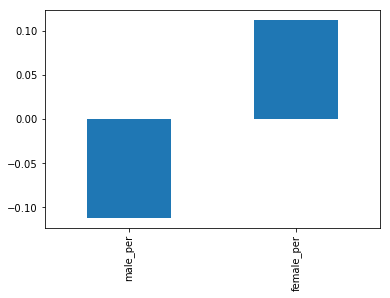

In [33]:
correlations.loc[['male_per','female_per']].plot.bar()

Smallish positive correlation between female percentage and sat score. Corresponding small negative correlation between male percentage and SAT score.

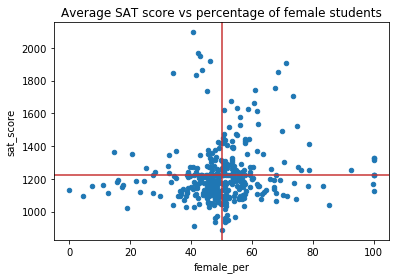

In [35]:
combined.plot.scatter('female_per','sat_score')
plt.axhline(avg_sat, c=(200/255, 50/255, 50/255))
plt.axvline(50, c=(200/255, 50/255, 50/255))
plt.title('Average SAT score vs percentage of female students')

Difficult to spot interesting results here, which is unsurprising since the correlation was fairly low. There do seem to be more schools in the top right quarter, but no particularly obvious clustering.

In [38]:
# Closer look at the schools in the very top right of the graph
combined[['school_name','female_per','sat_score']][(combined['female_per'] > 60) & (combined['sat_score']>1700)]

,school_name,female_per,sat_score
5,Bard High School Early College,68.7,1856.0
26,Eleanor Roosevelt High School,67.5,1758.0
60,Beacon High School,61.0,1744.0
61,Fiorello H. LaGuardia High School of Music & A...,73.6,1707.0
302,Townsend Harris High School,71.1,1910.0


These schools all appear to be selective, which explains their higher than average sat scores. With the exception of Townsend Harris, these schools seem to focus primarily on liberal arts subjects. It is plausible that this subject focus explains the higher percentage of female students.

# AP Exam takers percentage
The advance placement (AP) exam is generally taken by high achieving high school students as an early contribution to their higher education courses. We'll take a look at how the percentage of ap test takers at a school is related to the school's average SAT results.

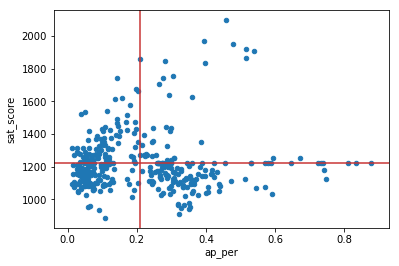

In [41]:
# Create an AP taker percentage column in our combined dataset
combined['ap_per'] = combined['ap_test_takers_'] / combined['total_enrollment']

# Scatter plot with lines for average sat score and average ap test takers percentage
combined.plot.scatter('ap_per','sat_score')
plt.axhline(avg_sat, c=(200/255,50/255,50/255))
plt.axvline(combined['ap_per'].mean(),c=(200/255,50/255,50/255))

Here there are two obvious clusters, and two obvious lines extending from these clusters. The line extending to the top right is fairly understandable: Schools that achieve good SAT results have more students taking AP exams.
The second line is more confusing: There seem to be a number of schools with higher percentages of students taking AP exams despite very average SAT scores for the school overall. We'll have a look at those schools.

In [42]:
combined[['school_name','sat_score','ap_per']][(combined['ap_per']>0.7) & (combined['sat_score']<1300)]

,school_name,sat_score,ap_per
6,47 The American Sign Language and English Seco...,1182.000000,0.741545
31,MANHATTAN ACADEMY FOR ARTS & LANGUAGE,1223.438806,0.737308
33,International High School at Union Square,1223.438806,0.733118
83,High School for Excellence and Innovation,1223.438806,0.724881
111,BRONX BRIDGES HIGH SCHOOL,1223.438806,0.832444
208,Frances Perkins Academy,1122.000000,0.745831
222,The Brooklyn Academy of Global Finance,1223.438806,0.811502
335,Cambria Heights Academy,1223.438806,0.877747


# Class Size

0.38101433081


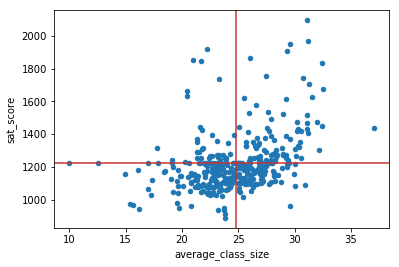

In [46]:
print(correlations['average_class_size'])
combined.plot.scatter('average_class_size','sat_score')
plt.axhline(avg_sat, c=(200/255,50/255,50/255))
plt.axvline(combined['average_class_size'].mean(),c=(200/255,50/255,50/255))

Somewhat surprisingly, the correlation between class size and average sat score is positive.

Anyhow, here we have combined data from various different sources files, cleaned it up a bit, and started some intiial investigation into the correlations it contains. The final dataset is incredibly rich, so we could study it almost indefinitely but we will stop here for now.